In [1]:
# Required packages
# !pip install triton
import torch
import triton
import triton.language as tl
import time
import matplotlib.pyplot as plt

In [2]:
@triton.jit
def my_triton_kernel(
    I_ptr, F_ptr, O_ptr,
    C, H, W, FH, FW,
    stride_h, stride_w, pad_h, pad_w,
    BLOCK_H: tl.constexpr, BLOCK_W: tl.constexpr,
):
    batch_idx = tl.program_id(0)
    x = tl.arange(0, BLOCK_W) + tl.program_id(1) * BLOCK_W
    y = tl.arange(0, BLOCK_H) + tl.program_id(2) * BLOCK_H

    mask_x = x < W
    mask_y = y < H
    acc = tl.zeros((BLOCK_H, BLOCK_W), dtype=tl.float32)

    for c in range(C):
        for i in range(FH):
            for j in range(FW):
                xi = x * stride_w + j - pad_w
                yi = y * stride_h + i - pad_h
                valid_xi = (xi >= 0) & (xi < W)
                valid_yi = (yi >= 0) & (yi < H)
                mask_valid = valid_xi[None, :] & valid_yi[:, None]

                input_ptrs = I_ptr + batch_idx * C * H * W + c * H * W + yi[:, None] * W + xi[None, :]
                filter_ptr = F_ptr + c * FH * FW + i * FW + j

                input_vals = tl.load(input_ptrs, mask=mask_valid, other=0.0)
                filter_val = tl.load(filter_ptr)
                acc += input_vals * filter_val

    output_ptrs = O_ptr + batch_idx * H * W + y[:, None] * W + x[None, :]
    tl.store(output_ptrs, acc, mask=mask_x[None, :] & mask_y[:, None])


def my_conv2d(I, F, stride_h=1, stride_w=1, padding=(0, 0)):
    B, C, H, W = I.shape
    K, _, FH, FW = F.shape
    pad_h, pad_w = padding

    OH = (H + 2 * pad_h - FH) // stride_h + 1
    OW = (W + 2 * pad_w - FW) // stride_w + 1
    O = torch.empty((B, K, OH, OW), device=I.device, dtype=I.dtype)

    grid = (B, (OW + 31) // 32, (OH + 31) // 32)
    my_triton_kernel[grid](
        I, F, O,
        C, OH, OW, FH, FW,
        stride_h, stride_w, pad_h, pad_w,
        BLOCK_H=32, BLOCK_W=32
    )
    return O


In [3]:
# Generate input and filter for C4
I = torch.randn((1, 3, 1024, 1024), device='cuda', dtype=torch.float32)
F = torch.randn((64, 3, 3, 3), device='cuda', dtype=torch.float32)

# Warm-up run to stabilize timings
triton_output = my_conv2d(I, F, stride_h=1, stride_w=1, padding=(1, 1))
torch.cuda.synchronize()

# Measure Triton convolution execution time after warm-up
torch.cuda.synchronize()
start_time = time.time()
triton_output = my_conv2d(I, F, stride_h=1, stride_w=1, padding=(1, 1))
torch.cuda.synchronize()
end_time = time.time()

# Print the execution time in milliseconds
execution_time = (end_time - start_time) * 1000
print(f"C4_execution_time: {execution_time:.3f} ms")


C4_execution_time: 8.621 ms


Maximum absolute error: 0.000000
Mean absolute error: 0.000000


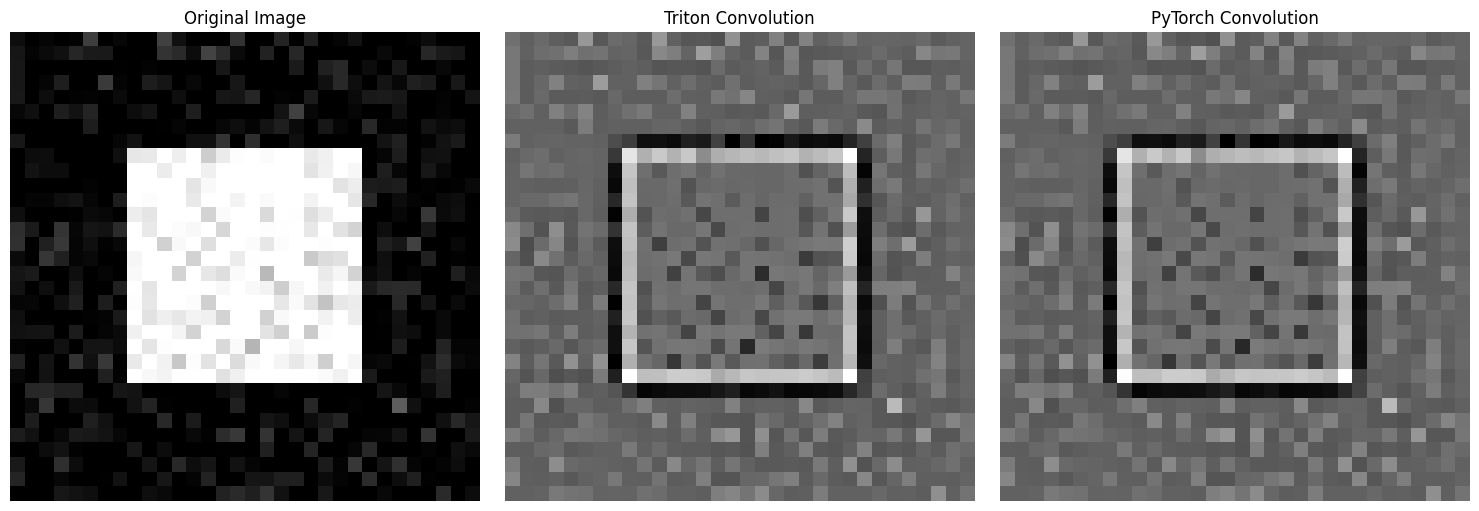


Performance Comparison on 224x224 images:
Triton implementation: 0.04 ms per batch
PyTorch implementation: 0.48 ms per batch
Speedup: 11.99x


In [4]:
# Edge Detection Kernel
def create_edge_detection_kernel():
    kernel = torch.tensor([
        [-1, -1, -1],
        [-1,  8, -1],
        [-1, -1, -1]
    ], dtype=torch.float32).cuda()
    return kernel.view(1, 1, 3, 3)

# Create a test image with a square in the middle
def create_test_image(size=32):
    image = torch.zeros((size, size), dtype=torch.float32)
    center = size // 4
    image[center:3*center, center:3*center] = 1.0
    image += torch.randn_like(image) * 0.1  # Add some noise
    return image.clamp(0, 1)

# Generate test data
test_image = create_test_image(32)
input_tensor = test_image.view(1, 1, 32, 32).cuda()
kernel_tensor = create_edge_detection_kernel()

# Triton convolution with padding
triton_output = my_conv2d(input_tensor, kernel_tensor, stride_h=1, stride_w=1, padding=(1, 1))

# PyTorch convolution with the same padding
torch_output = torch.nn.functional.conv2d(input_tensor, kernel_tensor, stride=1, padding=1)

# Calculate error
max_error = torch.max(torch.abs(triton_output - torch_output))
mean_error = torch.mean(torch.abs(triton_output - torch_output))

print(f"Maximum absolute error: {max_error:.6f}")
print(f"Mean absolute error: {mean_error:.6f}")

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(test_image.cpu().numpy(), cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(132)
plt.imshow(triton_output[0, 0].cpu().numpy(), cmap='gray')
plt.title('Triton Convolution')
plt.axis('off')

plt.subplot(133)
plt.imshow(torch_output[0, 0].cpu().numpy(), cmap='gray')
plt.title('PyTorch Convolution')
plt.axis('off')
plt.tight_layout()
plt.show()

input_large = torch.randn(16, 3, 224, 224, device='cuda')
kernel_large = torch.randn(64, 3, 3, 3, device='cuda')

# Warm-up runs
for _ in range(10):
    triton_output = my_conv2d(input_large, kernel_large, stride_h=1, stride_w=1, padding=(1, 1))
    torch_output = torch.nn.functional.conv2d(input_large, kernel_large, stride=1, padding=1)

# Timing Triton implementation
torch.cuda.synchronize()
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()
for _ in range(100):
    triton_output = my_conv2d(input_large, kernel_large, stride_h=1, stride_w=1, padding=(1, 1))
end.record()
torch.cuda.synchronize()
triton_time = start.elapsed_time(end) / 100

# Timing PyTorch implementation
start.record()
for _ in range(100):
    torch_output = torch.nn.functional.conv2d(input_large, kernel_large, stride=1, padding=1)
end.record()
torch.cuda.synchronize()
torch_time = start.elapsed_time(end) / 100

print("\nPerformance Comparison on 224x224 images:")
print(f"Triton implementation: {triton_time:.2f} ms per batch")
print(f"PyTorch implementation: {torch_time:.2f} ms per batch")
print(f"Speedup: {torch_time/triton_time:.2f}x")
